In [3]:
import pandas as pd
import os
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import proplot as pplt
from natsort import natsorted
import torch
from tqdm import tqdm
from twaidata.torchdatasets_v2.individual_dataset_wrappers import *
from trustworthai.journal_run.evaluation.new_scripts.eval_helper_functions import *

In [4]:
lbc_ds = LBCInterRaterDataset()

In [12]:
vol1 = []
vol2 = []
dice = []
for (xs, ys, ind, _) in tqdm(lbc_ds):
    if 'wmh_flthresh' in ys.keys():
        wmh1 = ys['wmh']#.cuda()
        wmh2 = ys['wmh_flthresh']#.cuda()
        vol1.append(wmh1.sum().item())
        vol2.append(wmh2.sum().item())
        dice.append(fast_dice(wmh1, wmh2))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.76it/s]


In [13]:
df = pd.DataFrame({
    "WMH1_ml":torch.Tensor(vol1) * 0.003,
    "WMH2_ml":torch.Tensor(vol2) * 0.003,
    "DSC":torch.Tensor(dice)
})

In [60]:
def bland_altman_plot(ax, x, y, fontsize, anot_fontsize, title=True, ds_name=None):
    mean = (x + y) / 2
    diff = (x - y)
    percent_diff = 100 * diff / np.minimum(x, y)
    mean_percent_diff = np.mean(percent_diff)

    std = np.std(percent_diff, ddof=1)
    conf_bound_95 = 1.96 * std
    
    ax.scatter(mean, percent_diff, color='dark mint green', alpha=0.7, edgecolors='w', linewidth=0.5, s=50, zorder=3)
    
    ax_text_colour = 'black'

    # mean and 95% confidence lines
    ax.axhline(y=mean_percent_diff, color='gray')
    rhs_point = max(x) * 0.79
    ax.text(rhs_point, mean_percent_diff + 1, 'mean diff:', verticalalignment='bottom', horizontalalignment='left', fontsize=anot_fontsize, c=ax_text_colour)
    ax.text(rhs_point, mean_percent_diff - 3, f'{mean_percent_diff:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=anot_fontsize, c=ax_text_colour)
    ax.axhline(y=mean_percent_diff - conf_bound_95, color='gray', linestyle='--')
    ax.text(rhs_point, mean_percent_diff - conf_bound_95 + 1, '-1.96 SD:', verticalalignment='bottom', horizontalalignment='left', fontsize=anot_fontsize, c=ax_text_colour)
    ax.text(rhs_point, mean_percent_diff - conf_bound_95 - 3, f'{mean_percent_diff - conf_bound_95:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=anot_fontsize, c=ax_text_colour)
    ax.axhline(y=mean_percent_diff + conf_bound_95, color='gray', linestyle='--')
    ax.text(rhs_point, mean_percent_diff + conf_bound_95 + 1, '+1.96 SD:', verticalalignment='bottom', horizontalalignment='left', fontsize=anot_fontsize, c=ax_text_colour)
    ax.text(rhs_point, mean_percent_diff + conf_bound_95 - 3, f'{mean_percent_diff + conf_bound_95:.2f}', verticalalignment='top', horizontalalignment='left', fontsize=anot_fontsize, c=ax_text_colour)

    # point out influential outliers
    outlier_sd = 3
    for (m, pd) in zip(mean, percent_diff):
        if pd > mean_percent_diff + (3 * std) or pd < mean_percent_diff - (3 * std):
            # the +0.1 and -0.1 are adjustments so that the dashes are centered on the dot from above
            scatter = ax.scatter(m+0.1, pd-0.1, facecolors='none', edgecolors=ax_text_colour, linewidth=1, s=100, linestyle=':')
            ax.text(m + max(x) * 0.035, pd - 2, 'Influential Outlier', verticalalignment='center', horizontalalignment='left', fontsize=anot_fontsize, c=ax_text_colour)

    if title:
        ax.set_title("Bland Altman plot of Analyst WMH Volumes", fontsize=fontsize+2)
    ax.set_ylabel("WMH Vol. % Difference", fontsize=fontsize)
    ax.set_xlabel(r"Mean WMH Volume (ml)", fontsize=fontsize)
    
    if ds_name:
        ax.text(x=0.97, y=0.97, s=ds_name, ha='right', va='top', transform=ax.transAxes, fontsize=15, fontweight='bold')

### publication plots

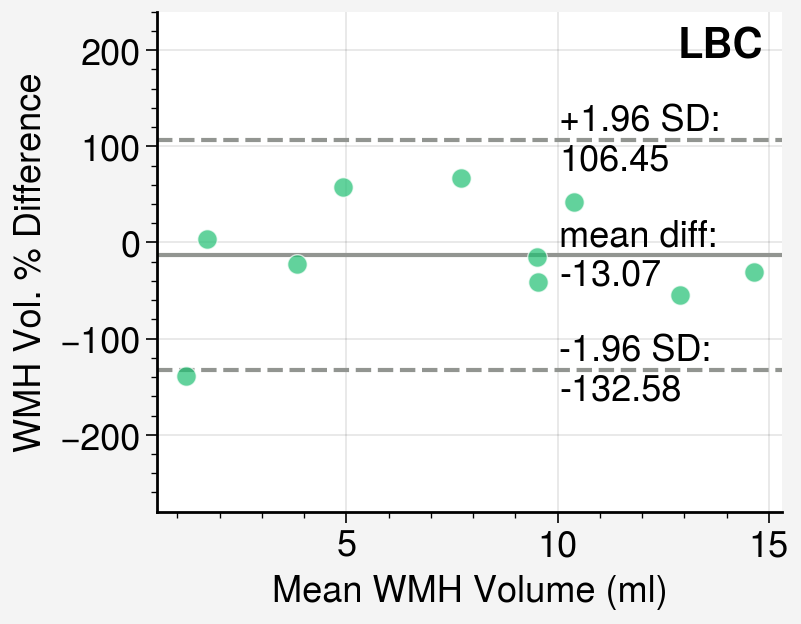

In [62]:
fig = pplt.figure(refwidth="25em", refheight="20em", span=False, share=False)
axs = fig.subplots(nrows=1, ncols=1)

fontsize=13

x = df["WMH1_ml"]
y = df["WMH2_ml"]
bland_altman_plot(axs[0], x, y, fontsize, fontsize, title=False, ds_name="LBC")
axs[0].set_ylim((-280, 240))

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.)
    ax.spines['bottom'].set_linewidth(1.)
    plt.minorticks_on()
    ax.tick_params(axis='both', labelsize=fontsize)

fig.save("bland altman lbc.pdf")